<a href="https://colab.research.google.com/github/Lubricy/notebooks/blob/master/sts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.x
!pip install --upgrade tensorflow-probability
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

print(tf.version.VERSION)
print(tfp.python.version.__version__)
print(tf.test.gpu_device_name())

TensorFlow 2.x selected.
Requirement already up-to-date: tensorflow-probability in /usr/local/lib/python3.6/dist-packages (0.8.0)
2.1.0-rc1
0.8.0
/device:GPU:0


In [3]:
import pandas as pd
import urllib

COIN_NAMES=['BTC', 'ETH', 'LTC']

data={}
for coin in COIN_NAMES:
  with urllib.request.urlopen(f"http://www.cryptodatadownload.com/cdd/Coinbase_{coin}USD_1h.csv") as f:
    print(next(f))
    data[coin] = pd.read_csv(f)

b'Timestamps are UTC timezone,https://www.CryptoDataDownload.com\r\n'
b'Timestamps are UTC timezone,https://www.CryptoDataDownload.com\r\n'
b'Timestamps are UTC timezone,https://www.CryptoDataDownload.com\r\n'


In [0]:
# data cleaning

for _, df in data.items():
  df['Date']= pd.to_datetime(df['Date'], format='%Y-%m-%d %I-%p') 

In [5]:
#@title COIN
COIN = 'ETH' #@param ['BTC', 'ETH', 'LTC']
display(data[COIN].columns)
display(data[COIN])
display(data[COIN].dtypes)

Index(['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume ETH',
       'Volume USD'],
      dtype='object')

,Date,Symbol,Open,High,Low,Close,Volume ETH,Volume USD
0,2020-01-03 05:00:00,ETHUSD,129.15,129.67,129.15,129.67,0.00,0.00
1,2020-01-03 04:00:00,ETHUSD,126.52,129.83,126.51,129.15,6913.15,887534.69
2,2020-01-03 03:00:00,ETHUSD,126.61,126.69,126.23,126.52,1669.17,210999.73
3,2020-01-03 02:00:00,ETHUSD,125.63,126.65,125.53,126.61,1713.95,216113.05
4,2020-01-03 01:00:00,ETHUSD,126.65,126.65,125.52,125.63,2631.28,331890.80
...,...,...,...,...,...,...,...,...
21974,2017-07-01 15:00:00,ETHUSD,265.74,272.74,265.00,272.57,5581.66,1500282.55
21975,2017-07-01 14:00:00,ETHUSD,268.79,269.90,265.00,265.74,6367.05,1702536.85
21976,2017-07-01 13:00:00,ETHUSD,274.83,274.93,265.00,268.79,11204.43,3010787.99
21977,2017-07-01 12:00:00,ETHUSD,275.01,275.01,271.00,274.83,3023.14,824362.87


Date          datetime64[ns]
Symbol                object
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume ETH           float64
Volume USD           float64
dtype: object

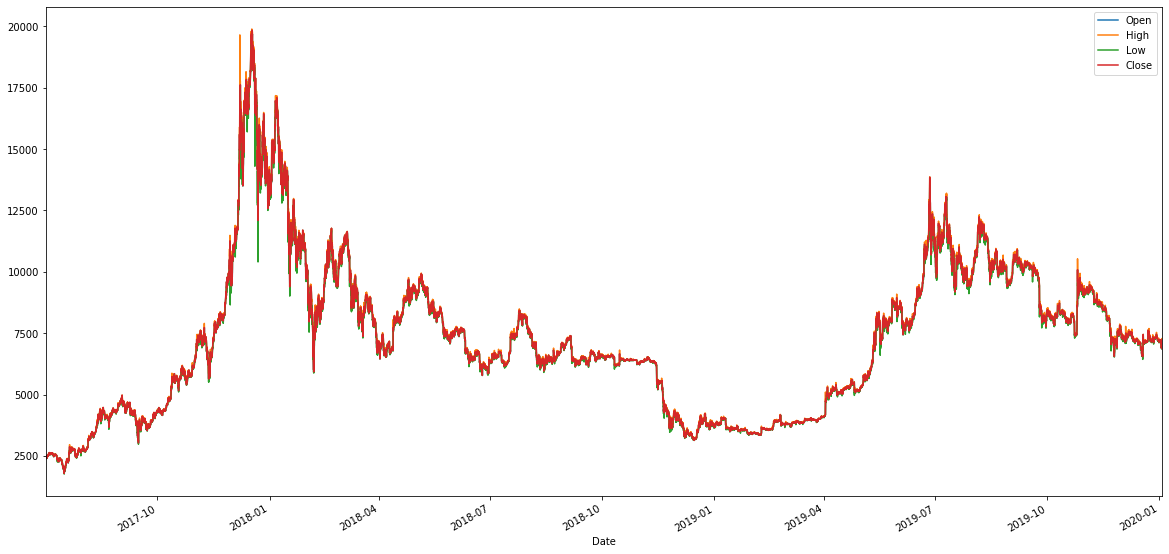

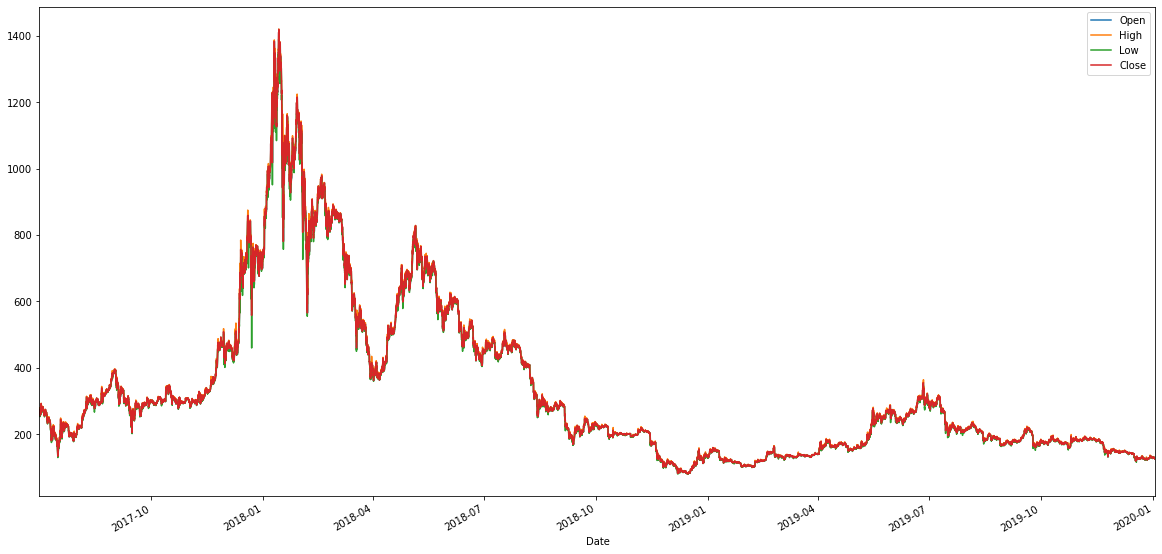

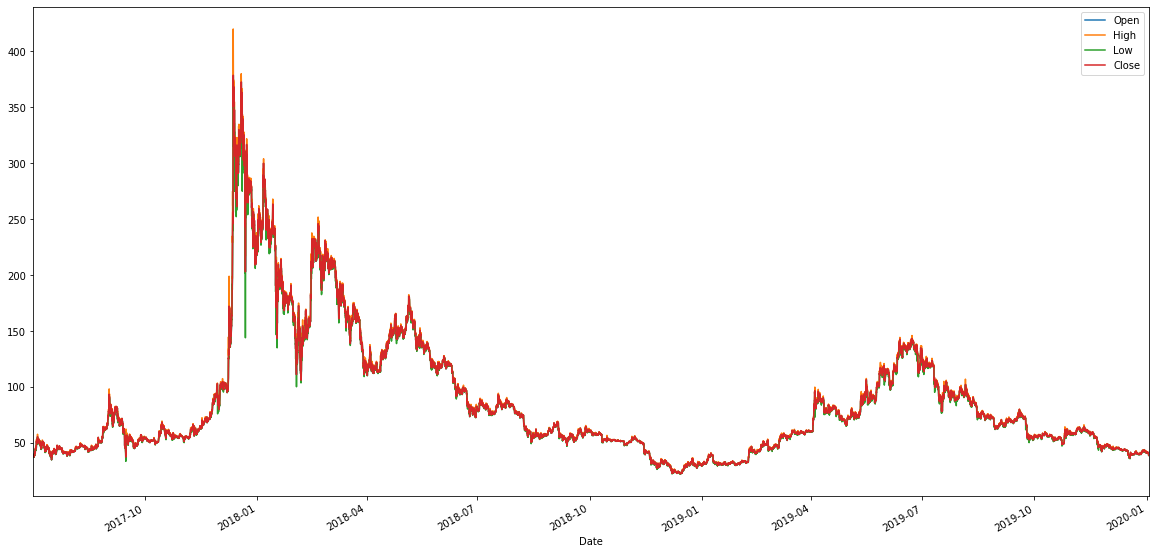

In [6]:
import matplotlib.pyplot as plt
for coin in COIN_NAMES:
  data[coin][['Date','Open', 'High', 'Low', 'Close']].plot(x='Date', figsize=(20,10))
  plt.show()

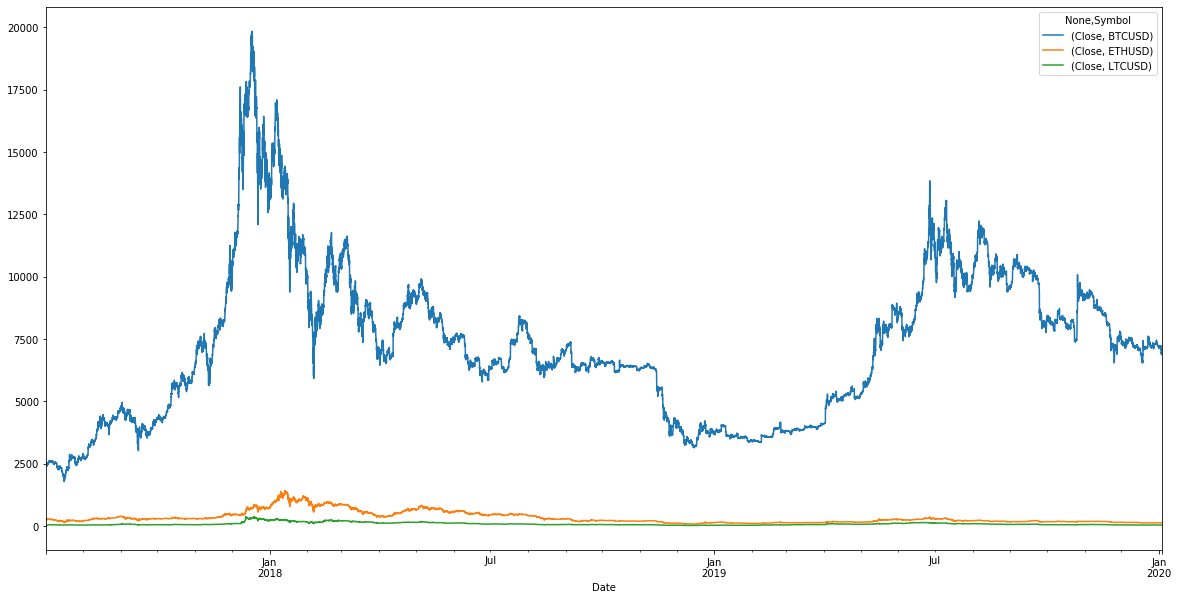

In [7]:
df = pd.concat(data.values(), sort=False).pivot(index='Date', columns='Symbol')
df[['Close']].plot(figsize=(20, 10))

In [8]:
obs = df[('Close', COIN+"USD")]
obs

Date
2017-07-01 11:00:00    275.01
2017-07-01 12:00:00    274.83
2017-07-01 13:00:00    268.79
2017-07-01 14:00:00    265.74
2017-07-01 15:00:00    272.57
                        ...  
2020-01-03 01:00:00    125.63
2020-01-03 02:00:00    126.61
2020-01-03 03:00:00    126.52
2020-01-03 04:00:00    129.15
2020-01-03 05:00:00    129.67
Name: (Close, ETHUSD), Length: 21979, dtype: float64

In [9]:
obs = np.array(df[('Close', COIN + "USD")])[:100]

hour_of_day_effect = tfp.sts.Seasonal(
    num_seasons=24,
    observed_time_series=obs,
    name='hour_of_day_effect')
day_of_week_effect = tfp.sts.Seasonal(
    num_seasons=7,
    num_steps_per_season=24, 
    observed_time_series=obs,
    name='day_of_week_effect')
residual_level = tfp.sts.Autoregressive(
    order=1,
    observed_time_series=obs, name='residual')
model = tfp.sts.Sum([ hour_of_day_effect,
                      day_of_week_effect,
                      residual_level],
                      observed_time_series=obs)

Instructions for updating:
Do not call `graph_parents`.


$z \sim N(0, 1)$

$x \sim N(z, 1)$

$P(z) = N(0, 1)$

$P(x|z) = N(z, 1)$

$P(x) = \int_z{P(x|z)P(z)dz}$

$D_{KL}[Q||P] = E_{z \sim Q}[log {Q(z) \over P(z|X)}] = \int_{z \sim Q} q(z)\log{q(z) \over p(z;X)}dz$ 

where $p$ and $q$ denote the probability densities of $P$ and $Q$


In [10]:
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

def log_prob(z, x):
  return tfd.Normal(0., 1.).log_prob(z) + tfd.Normal(z, 1.).log_prob(x)
conditioned_log_prob = lambda z: log_prob(z, x=5.)
q_z = tfd.Normal(loc=tf.Variable(0., name='q_z_loc'),
                 scale=tfp.util.DeferredTensor(
                   tf.nn.softplus,
                   tf.Variable(0., name='q_z_scale')), name='q_z')
losses = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    surrogate_posterior=q_z,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=1000)
print(q_z.mean(), q_z.stddev())  # => approximately [2.5, 1/sqrt(2)]
print([2.5, 1/np.sqrt(2)])

tf.Tensor(2.7075763, shape=(), dtype=float32) tf.Tensor(0.5831253, shape=(), dtype=float32)
[2.5, 0.7071067811865475]


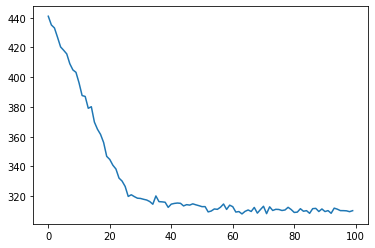

In [12]:
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=model)
num_variational_steps =  100 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_log_prob(
        observed_time_series=obs),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples= variational_posteriors.sample(50)

In [16]:
print("Inferred parameters:")
for param in model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples[param.name], axis=0),
                              np.std(q_samples[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.2442255023775094 +- 0.2638368261154814
hour_of_day_effect/_drift_scale: 0.06523826544728266 +- 0.07059333496845564
day_of_week_effect/_drift_scale: 2.774885667330405 +- 7.752535418747988
residual/_coefficients: [0.90971321] +- [0.08951147]
residual/_level_scale: 3.1317039553805506 +- 0.2583935378672804


In [0]:
num_forecast_steps = 10
forecast_dist = tfp.sts.forecast(
    model,
    observed_time_series=obs,
    parameter_samples=q_samples,
    num_steps_forecast=num_forecast_steps)

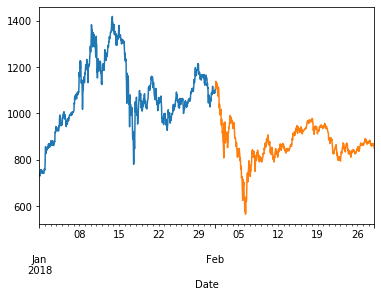

In [59]:
closed = df['Close'][COIN+'USD']

def slice(start=None, end=None):
  def _slice(df):
    return df[(df.index >= start) & (df.index < end)]
  return _slice

slice('2018-01-01', '2018-02-01')(closed).plot()
slice('2018-02-01', '2018-03-01')(closed).plot()
